In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件

import warnings
warnings.filterwarnings('ignore')

#系統操作、解壓縮檔案
import os
from zipfile import ZipFile

#機器學習
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV


# 設定 data_path
dir_data = './data/'

In [55]:
def model_roc_curve(fpr,tpr):
    plt.figure()
    lw = 2
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate',rotation=0, labelpad=30)
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

def  CM_plot(y_test, y_pred_binarized):
    plt.figure(figsize = (10, 8), dpi=72, 
               facecolor="white",edgecolor="green")
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred_binarized)
    plt.matshow(cnf_matrix,cmap = plt.cm.Blues) # 背景颜色
    plt.colorbar() # 颜色标签

    # 内部添加图例标签
    bbox = dict(boxstyle ="round", fc ="0.8")
    for x in range(len(cnf_matrix)):
        for y in range(len(cnf_matrix)):
            plt.annotate(cnf_matrix[x,y], xy = (x,y), bbox = bbox, horizontalalignment = 'center', verticalalignment = 'center')
    plt.ylabel('True Label',rotation=0, labelpad=20)
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix \n')
    plt.show()
    
def KPI(y_test,y_pred_binarized):
    accuracy=metrics.accuracy_score(y_test, y_pred_binarized)
    f1 = metrics.f1_score(y_test, y_pred_binarized) # 使用 F1-Score 評估
    precision = metrics.precision_score(y_test, y_pred_binarized) # 使用 Precision 評估
    recall  = metrics.recall_score(y_test, y_pred_binarized) # 使用 recall 評估
    print('Accuracy: ',accuracy)
    print("F1-Score: ", f1) 
    print("Precision: ", precision)
    print("Recall: ", recall)
    
    
def submit_save(model,f_name):
    test_X = df_mms[train_num:]
    print('test_X',test_X.shape)
    Y_pred = model.predict_proba(test_X,)[:,1]
    threshold = 0.5
    Y_pred_binarized = np.where(Y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
    submit = pd.DataFrame({'PassengerId':ids,'Survived':Y_pred_binarized})

    # 設定 data_path
    dir_save = './submit/'
    f_path = os.path.join(dir_save, f_name+'.csv')
    submit.to_csv(f_path, index = 0)

In [56]:
# 查看壓縮檔內的資料
f_path = os.path.join(dir_data, 'titanic.zip')
print('Path of read in data: %s' % (f_path))

myzip=ZipFile(f_path)
for i in myzip.filelist:
    print(i.filename)

Path of read in data: ./data/titanic.zip
gender_submission.csv
test.csv
train.csv


In [57]:
# 讀取壓縮檔內的資料
f=myzip.open('train.csv')
train=pd.read_csv(f)
f.close()

f=myzip.open('test.csv')
test=pd.read_csv(f)
f.close()

myzip.close()

# Data EDA & Features Selection

In [58]:
# 查看資料大小
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (891, 12)
Testing data shape:  (418, 11)


In [59]:
# 查看資料內容
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
        
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))        
        
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
    
columns_type(train)
object_check(train)
print('\n')
print('train data na_check')
na_check(train)
print('\n')
print('test data na_check')
na_check(test)

print('\n')
print('樣本平均存活機率 : {:.2f}'.format(train['Survived'].sum()/train.shape[0]))

類型 :  int64 

  個數 :  5 

   ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'] 

-----------------------------------------------

類型 :  float64 

  個數 :  2 

   ['Age', 'Fare'] 

-----------------------------------------------

類型 :  object 

  個數 :  5 

   ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] 

-----------------------------------------------



,Column,Unique Count
0,Name,891
1,Sex,2
2,Ticket,681
3,Cabin,147
4,Embarked,3




train data na_check


,Missing Ratio
Cabin,77.104377
Age,19.865320
Embarked,0.224467




test data na_check


,Missing Ratio
Cabin,78.229665
Age,20.574163
Fare,0.239234




樣本平均存活機率 : 0.38


In [60]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## First Features Selection

In [61]:
train_try = train.copy()

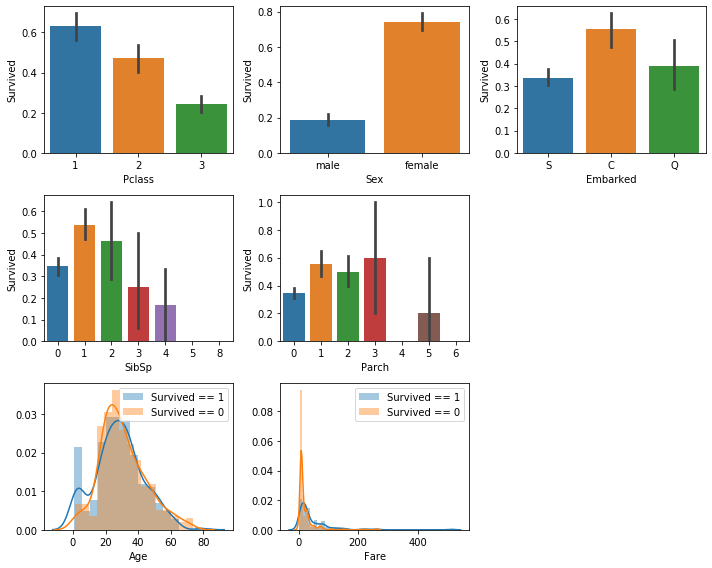

In [62]:
# 單變數

# 設定繪圖區域的長與寬
fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(3, 3, 1)
sns.barplot(x='Pclass',y='Survived',data=train_try)

ax_2 = fig.add_subplot(3, 3, 2)
sns.barplot(x='Sex',y='Survived',data=train_try)

ax_3 = fig.add_subplot(3, 3, 3)
sns.barplot(x='Embarked',y='Survived',data=train_try)

ax_4 = fig.add_subplot(3, 3, 4)
sns.barplot(x='SibSp',y='Survived',data=train_try)

ax_5 = fig.add_subplot(3, 3, 5)
sns.barplot(x='Parch',y='Survived',data=train_try)

ax_7 = fig.add_subplot(3, 3, 7)
sns.distplot(train_try.loc[train_try['Survived'] == 1, 'Age'], label = 'Survived == 1')
sns.distplot(train_try.loc[train_try['Survived'] == 0, 'Age'], label = 'Survived == 0')
ax_7.legend() # 圖例

ax_8 = fig.add_subplot(3, 3, 8)
sns.distplot(train_try.loc[train_try['Survived'] == 1, 'Fare'], label = 'Survived == 1')
sns.distplot(train_try.loc[train_try['Survived'] == 0, 'Fare'], label = 'Survived == 0')
ax_8.legend()

fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

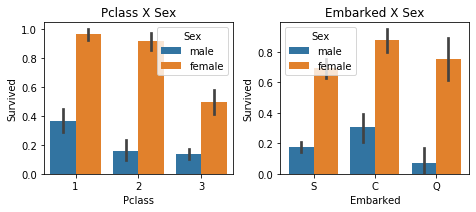

In [63]:
# 雙變數

fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(3, 3, 1)
sns.barplot(x='Pclass',y='Survived',hue='Sex',data=train_try)
ax_1.set_title("Pclass X Sex")

ax_2 = fig.add_subplot(3, 3, 2)
sns.barplot(x='Embarked',y='Survived',hue='Sex',data=train_try)
ax_2.set_title("Embarked X Sex")


fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

In [64]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
train_Y = train['Survived']
ids = test['PassengerId']
train_X = train.loc[:,['Pclass','Sex','Embarked']]
test_X = test.loc[:,['Pclass','Sex','Embarked']]
df = pd.concat([train_X,test_X], axis=0)

print('總資料維度(Train + test)',df.shape)
print('可特徵工程的欄位',list(df.columns))


# 'Embarked' 補NA
df['Embarked']=df['Embarked'].fillna('NA')

# GET DUMMIES
df_etl=pd.get_dummies(df,drop_first = True)
print('最終的欄位',list(df_etl.columns))


# 資料標準化 & 切割
df_mms = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_etl)
train_num = train_Y.shape[0]
train_X = df_mms[:train_num]
print('train_X',train_X.shape)

x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=12)


總資料維度(Train + test) (1309, 3)
可特徵工程的欄位 ['Pclass', 'Sex', 'Embarked']
最終的欄位 ['Pclass', 'Sex_male', 'Embarked_NA', 'Embarked_Q', 'Embarked_S']
train_X (891, 5)


Test Data 指標

Accuracy:  0.7649253731343284
F1-Score:  0.6315789473684211
Precision:  0.84375
Recall:  0.5046728971962616


roc_auc :  0.7896325535496603


<Figure size 432x288 with 0 Axes>

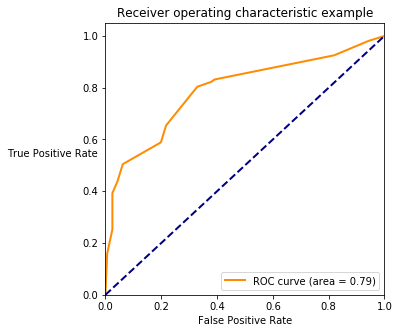

<Figure size 720x576 with 0 Axes>

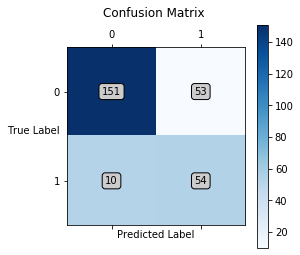

In [65]:
# 隨機森林 RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

model01 = RandomForestClassifier(random_state=12,min_samples_split=20)

model01.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model01.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model01.predict(x_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.7649253731343284
F1-Score:  0.6315789473684211
Precision:  0.84375
Recall:  0.5046728971962616


roc_auc :  0.7877169559412549


<Figure size 432x288 with 0 Axes>

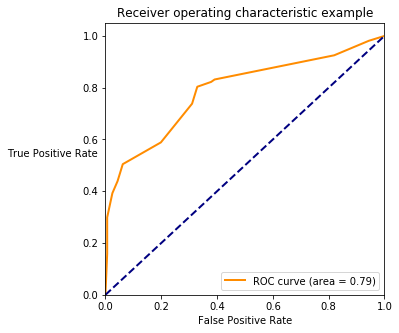

<Figure size 720x576 with 0 Axes>

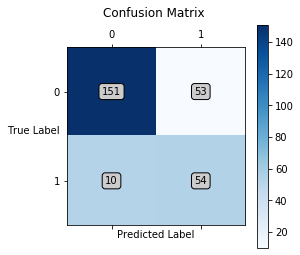

In [66]:
# GBDT (GradientBoostingClassifier)
from sklearn.ensemble import GradientBoostingClassifier

model02 = GradientBoostingClassifier(random_state=12,min_samples_split=20)

model02.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model02.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model02.predict(x_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

In [164]:
submit_save(model02,'model_base')

test_X (418, 5)


## Second Features Selection

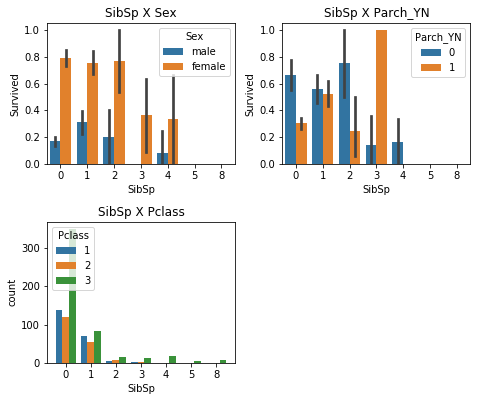

In [67]:
train_try = train.copy()

train_try['Parch_YN']=(train_try['Parch']==0).astype('int')

# 雙變數

fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(3, 3, 1)
sns.barplot(x='SibSp',y='Survived',hue='Sex',data=train_try)
ax_1.set_title("SibSp X Sex")

ax_2 = fig.add_subplot(3, 3, 2)
sns.barplot(x='SibSp',y='Survived',hue='Parch_YN',data=train_try)
ax_2.set_title("SibSp X Parch_YN")

ax_4 = fig.add_subplot(3, 3, 4)
sns.countplot(x='SibSp',hue='Pclass',data=train_try)
ax_4.set_title("SibSp X Pclass")


fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

In [68]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
train_Y = train['Survived']
ids = test['PassengerId']
train_X = train.loc[:,['Pclass','Sex','Embarked','SibSp','Parch']]
test_X = test.loc[:,['Pclass','Sex','Embarked','SibSp','Parch']]
df = pd.concat([train_X,test_X], axis=0)

#特徵工程
def SibSp_cut(x):
    if x < 3:
        return 'Sib_cut_less_3'
    elif x < 5:
        return 'Sib_cut_less_5'
    else:
        return 'Sib_cut_else'

df['SibSp_cut'] = df['SibSp'].apply(SibSp_cut,args=())
df['Parch_YN']=(df['Parch']==0).astype('int')

# Drop
df.drop(columns=['Parch_YN'],inplace=True)


print('總資料維度(Train + test)',df.shape)
print('可特徵工程的欄位',list(df.columns))

# 'Embarked' 補NA
df['Embarked']=df['Embarked'].fillna('NA')

# GET DUMMIES
df_etl=pd.get_dummies(df,drop_first = True)
print('最終的欄位',list(df_etl.columns))


# 資料標準化 & 切割
df_mms = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_etl)
train_num = train_Y.shape[0]
train_X = df_mms[:train_num]
print('train_X',train_X.shape)

x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=12)


總資料維度(Train + test) (1309, 6)
可特徵工程的欄位 ['Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch', 'SibSp_cut']
最終的欄位 ['Pclass', 'SibSp', 'Parch', 'Sex_male', 'Embarked_NA', 'Embarked_Q', 'Embarked_S', 'SibSp_cut_Sib_cut_less_3', 'SibSp_cut_Sib_cut_less_5']
train_X (891, 9)


Test Data 指標

Accuracy:  0.7611940298507462
F1-Score:  0.627906976744186
Precision:  0.8307692307692308
Recall:  0.5046728971962616


roc_auc :  0.8288152319034074


<Figure size 432x288 with 0 Axes>

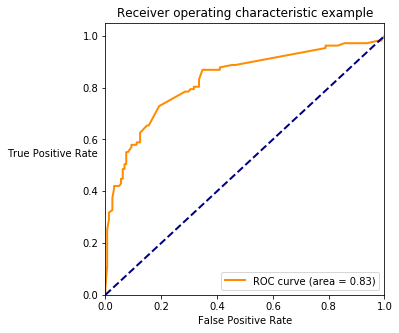

<Figure size 720x576 with 0 Axes>

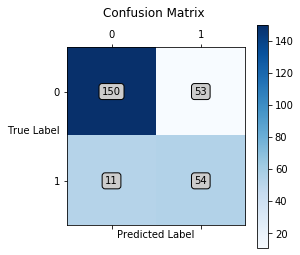

In [69]:
# 隨機森林 RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

model01 = RandomForestClassifier(random_state=12,min_samples_split=20)

model01.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model01.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model01.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.7723880597014925
F1-Score:  0.659217877094972
Precision:  0.8194444444444444
Recall:  0.5514018691588785


roc_auc :  0.8253613513670401


<Figure size 432x288 with 0 Axes>

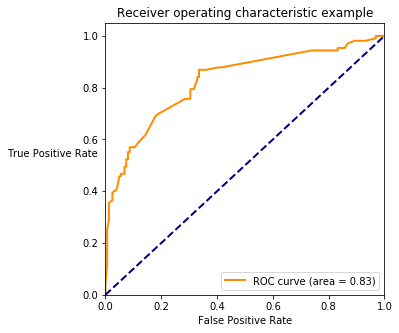

<Figure size 720x576 with 0 Axes>

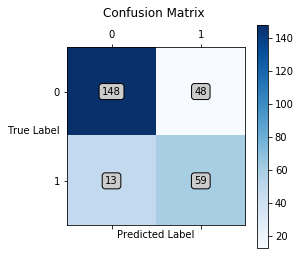

In [22]:
# GBDT (GradientBoostingClassifier)
from sklearn.ensemble import GradientBoostingClassifier

model02 = GradientBoostingClassifier(random_state=12,min_samples_split=20)

model02.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model02.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model02.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

In [168]:
submit_save(model02,'model_v2')

test_X (418, 9)


## Third Features Selection

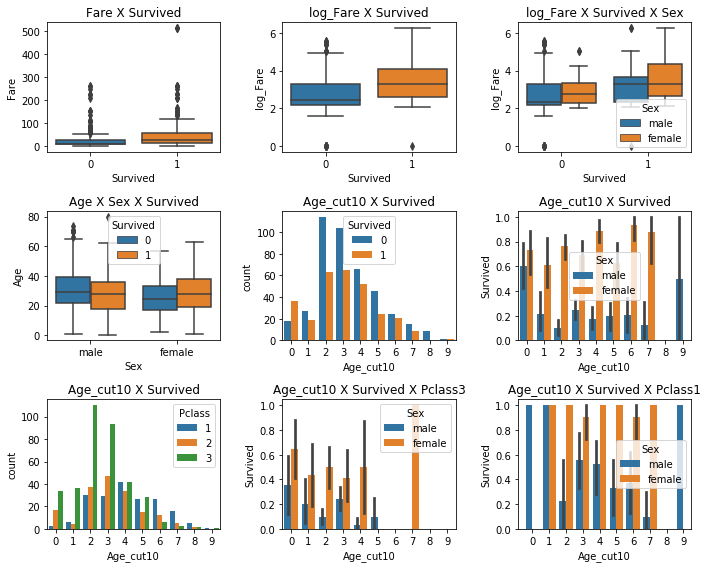

In [70]:
train_try = train.copy()

train_try['log_Fare'] = train_try['Fare'].apply(lambda x : np.log(x+1))
train_try['Age_cut10']=pd.cut(train_try['Age'],10,labels=range(10))

# 雙變數

fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(3, 3, 1)
sns.boxplot(y='Fare',x='Survived',data=train_try)
ax_1.set_title("Fare X Survived")

ax_2 = fig.add_subplot(3, 3, 2)
sns.boxplot(y='log_Fare',x='Survived',data=train_try)
ax_2.set_title("log_Fare X Survived")

ax_3 = fig.add_subplot(3, 3, 3)
sns.boxplot(y='log_Fare',x='Survived',hue='Sex',data=train_try)
ax_3.set_title("log_Fare X Survived X Sex")

ax_4 = fig.add_subplot(3, 3, 4)
sns.boxplot(y='Age',x='Sex',hue='Survived',data=train_try)
ax_4.set_title("Age X Sex X Survived")

ax_5 = fig.add_subplot(3, 3, 5)
sns.countplot(x='Age_cut10',hue='Survived',data=train_try)
ax_5.set_title("Age_cut10 X Survived")

ax_6 = fig.add_subplot(3, 3, 6)
sns.barplot(x='Age_cut10',y='Survived',hue='Sex',data=train_try)
ax_6.set_title("Age_cut10 X Survived")

ax_7 = fig.add_subplot(3, 3, 7)
sns.countplot(x='Age_cut10',hue='Pclass',data=train_try)
ax_7.set_title("Age_cut10 X Survived")

ax_8 = fig.add_subplot(3, 3, 8)
sns.barplot(x='Age_cut10',y='Survived',hue='Sex',data=train_try.loc[train_try.Pclass==3,:])
ax_8.set_title("Age_cut10 X Survived X Pclass3")

ax_9 = fig.add_subplot(3, 3, 9)
sns.barplot(x='Age_cut10',y='Survived',hue='Sex',hue_order=['male','female'],data=train_try.loc[train_try.Pclass==1,:])
ax_9.set_title("Age_cut10 X Survived X Pclass1")

fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

In [71]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
train_Y = train['Survived']
ids = test['PassengerId']
train_X = train.loc[:,['Pclass','Sex','Embarked','Fare','Age']]
test_X = test.loc[:,['Pclass','Sex','Embarked','Fare','Age']]
df = pd.concat([train_X,test_X], axis=0)

#####特徵工程
# 'Embarked' 補NA
df['Embarked']=df['Embarked'].fillna('NA')
# 'Fare' 補中位數
df['Fare'].fillna(df['Fare'].median(),inplace=True)
df['log_Fare'] = df['Fare'].apply(lambda x : np.log(x+1))
# 'Age' 補中位數
df['Age']=df['Age'].fillna(df['Age'].median())
df['Age_cut10']=pd.cut(df['Age'],10,labels=range(10)).astype('int')

def Age_cut10_cut(x):
    if x == 0:
        return 1
    elif x == 9:
        return 1
    else:
        return 0

df['Old_Child'] = df['Age_cut10'].apply(Age_cut10_cut,args=())



# Drop
df.drop(columns=['Fare','Age','Age_cut10'],inplace=True)


print('總資料維度(Train + test)',df.shape)
print('可特徵工程的欄位',list(df.columns))


# GET DUMMIES
df_etl=pd.get_dummies(df,drop_first = True)
print('最終的欄位',list(df_etl.columns))

# 資料標準化 & 切割
df_mms = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_etl)
train_num = train_Y.shape[0]
train_X = df_mms[:train_num]
print('train_X',train_X.shape)

x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=12)


總資料維度(Train + test) (1309, 5)
可特徵工程的欄位 ['Pclass', 'Sex', 'Embarked', 'log_Fare', 'Old_Child']
最終的欄位 ['Pclass', 'log_Fare', 'Old_Child', 'Sex_male', 'Embarked_NA', 'Embarked_Q', 'Embarked_S']
train_X (891, 7)


Test Data 指標

Accuracy:  0.7873134328358209
F1-Score:  0.6918918918918919
Precision:  0.8205128205128205
Recall:  0.5981308411214953


roc_auc :  0.852731177802287


<Figure size 432x288 with 0 Axes>

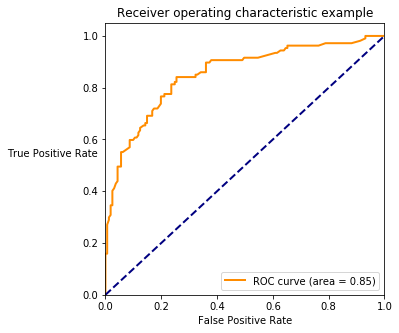

<Figure size 720x576 with 0 Axes>

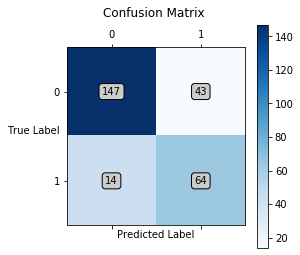

In [72]:
# 隨機森林 RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

model01 = RandomForestClassifier(random_state=12,min_samples_split=20)

model01.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model01.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model01.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.7985074626865671
F1-Score:  0.7096774193548387
Precision:  0.8354430379746836
Recall:  0.616822429906542


roc_auc :  0.8625994079061938


<Figure size 432x288 with 0 Axes>

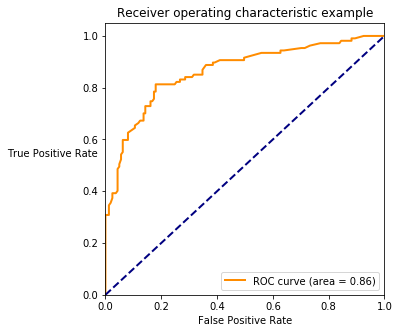

<Figure size 720x576 with 0 Axes>

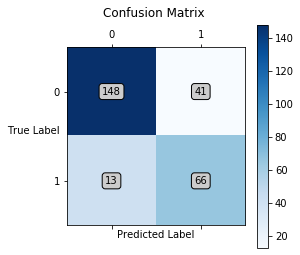

In [73]:
# GBDT (GradientBoostingClassifier)
from sklearn.ensemble import GradientBoostingClassifier

model02 = GradientBoostingClassifier(random_state=12,min_samples_split=20)

model02.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model02.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model02.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

In [39]:
submit_save(model02,'model_v3_2')

test_X (418, 7)


# Fourth Features Selection

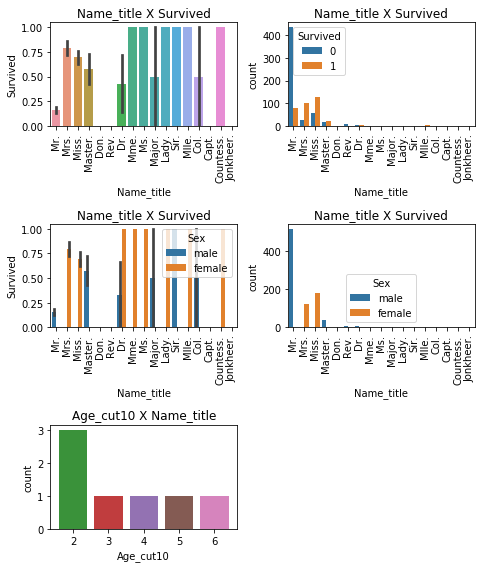

In [8]:
train_try = train.copy()

train_try['log_Fare'] = train_try['Fare'].apply(lambda x : np.log(x+1))
train_try['Age_cut10']=pd.cut(train_try['Age'],10,labels=range(10))
import re
pattern = re.compile('\S*\.')
train_try['Name_title'] = train_try['Name'].apply(lambda x: pattern.findall(x)[0])
'''
train_try['Name_title'] = train_try['Name_title'].map({'Mr.':'Mr.','Lady.':'Lady.','Mrs.':'Lady.','Miss.':'Lady.','Mme.':'Lady.','Ms.':'Lady.','Mlle.':'Lady.',
                             'Master.':'M.','Dr.':'M.','Major.':'M.','Col.':'M.','Sir.':'Sir.','Countess.':'Sir.'})
train_try['Name_title'].fillna('NA',inplace=True)
'''
# 雙變數

fig = plt.figure(figsize = (10, 8), dpi=72, 
           facecolor="white",edgecolor="green")

# 設定子圖
ax_1 = fig.add_subplot(3, 3, 1)
sns.barplot(x='Name_title',y='Survived',data=train_try)
ax_1.set_title("Name_title X Survived")
#plt.xticks(rotation=90)
ax_1.tick_params(axis='x', labelrotation= 90)

ax_2 = fig.add_subplot(3, 3, 2)
sns.countplot(x='Name_title',hue='Survived',data=train_try)
ax_2.set_title("Name_title X Survived")
ax_2.tick_params(axis='x', labelrotation= 90)

ax_4 = fig.add_subplot(3, 3, 4)
sns.barplot(x='Name_title',y='Survived',hue='Sex',data=train_try)
ax_4.set_title("Name_title X Survived")
ax_4.tick_params(axis='x', labelrotation= 90)

ax_5 = fig.add_subplot(3, 3, 5)
sns.countplot(x='Name_title',hue='Sex',data=train_try)
ax_5.set_title("Name_title X Survived")
ax_5.tick_params(axis='x', labelrotation= 90)

ax_7 = fig.add_subplot(3, 3, 7)
sns.countplot(x='Age_cut10',data=train_try.loc[train_try.Name_title.isin(['Lady.','Mme.','Ms.','Mlle.','Sir.','Countess.'])])
ax_7.set_title("Age_cut10 X Name_title")

fig.tight_layout() # 子圖間距
plt.plot()
plt.show()

In [81]:
pd.get_dummies(df['Embarked'],drop_first = False)

,C,NA,Q,S
0,0,0,0,1
1,1,0,0,0
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
413,0,0,0,1
414,1,0,0,0
415,0,0,0,1
416,0,0,0,1


In [80]:
df['Embarked'].

0      S
1      C
2      S
3      S
4      S
      ..
413    S
414    C
415    S
416    S
417    C
Name: Embarked, Length: 1309, dtype: object

In [77]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
train_Y = train['Survived']
ids = test['PassengerId']
train_X = train.loc[:,['Pclass','Sex','Embarked','Fare','Age','Name']]
test_X = test.loc[:,['Pclass','Sex','Embarked','Fare','Age','Name']]
df = pd.concat([train_X,test_X], axis=0)

#####特徵工程
# 'Embarked' 補NA
df['Embarked']=df['Embarked'].fillna('NA')
# 'Fare' 補中位數
df['Fare'].fillna(df['Fare'].median(),inplace=True)
df['log_Fare'] = df['Fare'].apply(lambda x : np.log(x+1))
# 'Age' 補中位數
df['Age']=df['Age'].fillna(df['Age'].median())
df['Age_cut10']=pd.cut(df['Age'],10,labels=range(10)).astype('int')

def Age_cut10_cut(x):
    if x == 0:
        return 1
    elif x == 9:
        return 1
    else:
        return 0

df['Old_Child'] = df['Age_cut10'].apply(Age_cut10_cut,args=())

# 'Name'
pattern = re.compile('\S*\.')
df['Name_title'] = df['Name'].apply(lambda x: pattern.findall(x)[0])
df['Name_title_Capt'] = (df['Name_title'] == 'Capt.').astype('int')

'''
df['Name_title_Great'] = (df.Name_title.isin(['Lady.','Mme.','Ms.','Mlle.','Sir.','Countess.'])).astype('int')
df['Name_title'] = df['Name_title'].map({'Mr.':'Mr.','Lady.':'Lady.','Mrs.':'Lady.','Miss.':'Lady.','Mme.':'Lady.','Ms.':'Lady.','Mlle.':'Lady.',
                             'Master.':'M.','Dr.':'M.','Major.':'M.','Col.':'M.','Sir.':'Sir.','Countess.':'Sir.'})
df['Name_title'].fillna('NA',inplace=True)
'''

# Drop
df.drop(columns=['Fare','Age','Age_cut10','Name','Name_title'],inplace=True)


print('總資料維度(Train + test)',df.shape)
print('可特徵工程的欄位',list(df.columns))


# GET DUMMIES
df_etl=pd.get_dummies(df,drop_first = True)
print('最終的欄位',list(df_etl.columns))

# 資料標準化 & 切割
df_mms = MinMaxScaler(feature_range=(0, 1)).fit_transform(df_etl)
train_num = train_Y.shape[0]
train_X = df_mms[:train_num]
print('train_X',train_X.shape)

x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=12)


總資料維度(Train + test) (1309, 6)
可特徵工程的欄位 ['Pclass', 'Sex', 'Embarked', 'log_Fare', 'Old_Child', 'Name_title_Capt']
最終的欄位 ['Pclass', 'log_Fare', 'Old_Child', 'Name_title_Capt', 'Sex_male', 'Embarked_NA', 'Embarked_Q', 'Embarked_S']
train_X (891, 8)


Test Data 指標

Accuracy:  0.7873134328358209
F1-Score:  0.6951871657754011
Precision:  0.8125
Recall:  0.6074766355140186


roc_auc :  0.8525860567713471


<Figure size 432x288 with 0 Axes>

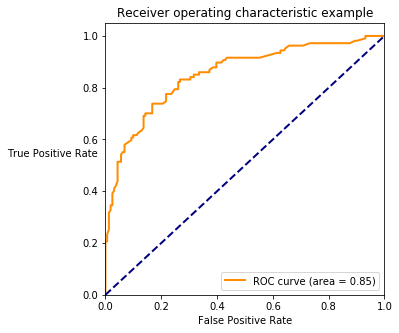

<Figure size 720x576 with 0 Axes>

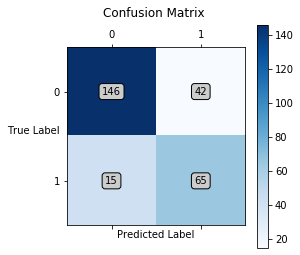

In [78]:
# 隨機森林 RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

model01 = RandomForestClassifier(random_state=12,min_samples_split=20)

model01.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model01.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model01.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

Test Data 指標

Accuracy:  0.8059701492537313
F1-Score:  0.7234042553191489
Precision:  0.8395061728395061
Recall:  0.6355140186915887


roc_auc :  0.864602078133163


<Figure size 432x288 with 0 Axes>

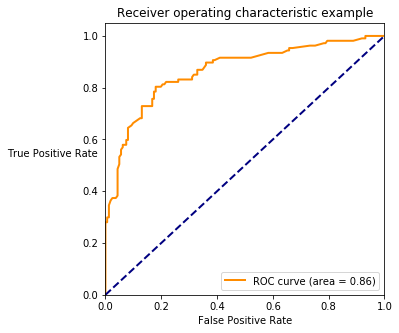

<Figure size 720x576 with 0 Axes>

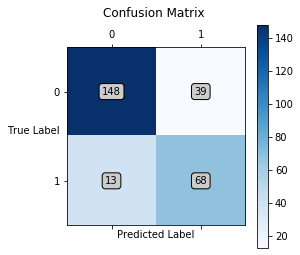

In [79]:
# GBDT (GradientBoostingClassifier)
from sklearn.ensemble import GradientBoostingClassifier

model02 = GradientBoostingClassifier(random_state=12,min_samples_split=20)

model02.fit(x_train, y_train)

print('Test Data 指標\n')
try:
    y_pred = model02.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model02.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)

In [95]:
submit_save(model02,'model_v4_6')

test_X (418, 9)


# Model & Parameters Selection

In [50]:
# 設定要訓練的超參數組合
n_estimators = [200, 300,400]
min_samples_split=[20]
max_depth = [3, 4, 5]
param_grid = dict(n_estimators=n_estimators, min_samples_split=min_samples_split,
                 max_depth = max_depth)

## 建立搜尋物件，放入模型及參數組合字典 (n_jobs=-1 會使用全部 cpu 平行運算)
grid_search = GridSearchCV(model02, param_grid, n_jobs=-1, verbose=1,
                          scoring='roc_auc',cv=5)

# 開始搜尋最佳參數
grid_result = grid_search.fit(x_train, y_train)

# 預設會跑 5-fold cross-validadtion，總共 27 種參數組合，總共要 train 45 次模型

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    7.3s finished


In [51]:
# 印出最佳結果與最佳參數
print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best Accuracy: 0.884328 using {'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 200}


Test Data 指標

Accuracy:  0.8022388059701493
F1-Score:  0.7414634146341462
Precision:  0.7755102040816326
Recall:  0.7102803738317757


roc_auc :  0.8578394380913682


<Figure size 432x288 with 0 Axes>

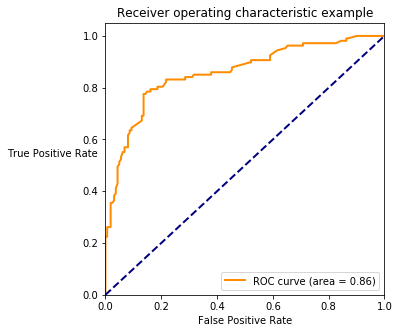

<Figure size 720x576 with 0 Axes>

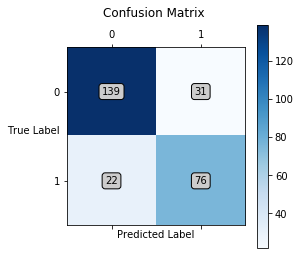

In [52]:
# GBDT (GradientBoostingClassifier)
from sklearn.ensemble import GradientBoostingClassifier

model02 = GradientBoostingClassifier(random_state=12,
                                    min_samples_split=grid_result.best_params_['min_samples_split'],
                                    n_estimators=grid_result.best_params_['n_estimators'],
                                    max_depth=grid_result.best_params_['max_depth'])

model02.fit(x_train, y_train)


print('Test Data 指標\n')
try:
    y_pred = model02.predict_proba(x_test,)[:,1]
    threshold = 0.5
    y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
except:
    y_pred_binarized = model02.predict(X_test,)
KPI(y_test,y_pred_binarized)
print('\n')
fpr,tpr,threshold = metrics.roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = metrics.auc(fpr,tpr) ###計算auc的值
print('roc_auc : ',roc_auc)
model_roc_curve(fpr=fpr,tpr=tpr)
CM_plot(y_test, y_pred_binarized)


In [53]:
submit_save(model02,'model_v4_6_2')

test_X (418, 8)


In [97]:
'''
df_etl = df.copy()
# 'Pclass' OK

# 'SibSp', 'Parch' OK
df_etl['Total_Family']=df_etl['SibSp'] + df_etl['Parch']
df_etl['Total_Family_cut3']=0
df_etl['Total_Family_cut3'][df_etl['Total_Family']!=0]=np.array(pd.cut(df_etl['Total_Family'][df_etl['Total_Family']!=0],3,labels=[1,2,3]))
# 'Age' 補中位數
df_etl['Age']=df_etl['Age'].fillna(df_etl['Age'].median())

# 'Fare'
df_etl['Fare_qcut10']=pd.qcut(df_etl['Fare'],10,labels=range(10))

# 'Name' 
import re
pattern = re.compile('\S*\.')
df_etl['Name_title'] = df_etl['Name'].apply(lambda x: pattern.findall(x)[0])

# 'Sex' OK

# 'Ticket'
Ticket_c=df_etl.groupby(['Ticket'])['Name'].count().reset_index(name='n')
df_etl['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket'])
df_etl['tkts']=df['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket']).astype('int')

# 'Cabin' 補NA
df_etl['Cabin']=df_etl['Cabin'].fillna('NA')
df_etl['Cabin_sub']=df_etl['Cabin'].apply(lambda x:x[0])

# 'Embarked' 補NA
df_etl['Embarked']=df_etl['Embarked'].fillna('NA')


# drop
df_etl=df_etl.drop(columns=['Total_Family'])
df_etl=df_etl.drop(columns=['Name'])
df_etl=df_etl.drop(columns=['Ticket'])
df_etl=df_etl.drop(columns=['Cabin'])

# GET DUMMIES
df_etl=pd.get_dummies(df_etl,drop_first = True)
df_etl.head(10)
'''

"\ndf_etl = df.copy()\n# 'Pclass' OK\n\n# 'SibSp', 'Parch' OK\ndf_etl['Total_Family']=df_etl['SibSp'] + df_etl['Parch']\ndf_etl['Total_Family_cut3']=0\ndf_etl['Total_Family_cut3'][df_etl['Total_Family']!=0]=np.array(pd.cut(df_etl['Total_Family'][df_etl['Total_Family']!=0],3,labels=[1,2,3]))\n# 'Age' 補中位數\ndf_etl['Age']=df_etl['Age'].fillna(df_etl['Age'].median())\n\n# 'Fare'\ndf_etl['Fare_qcut10']=pd.qcut(df_etl['Fare'],10,labels=range(10))\n\n# 'Name' \nimport re\npattern = re.compile('\\S*\\.')\ndf_etl['Name_title'] = df_etl['Name'].apply(lambda x: pattern.findall(x)[0])\n\n# 'Sex' OK\n\n# 'Ticket'\nTicket_c=df_etl.groupby(['Ticket'])['Name'].count().reset_index(name='n')\ndf_etl['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket'])\ndf_etl['tkts']=df['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket']).astype('int')\n\n# 'Cabin' 補NA\ndf_etl['Cabin']=df_etl['Cabin'].fillna('NA')\ndf_etl['Cabin_sub']=df_etl['Cabin'].apply(lambda x:x[0])\n\n# 'Embarked' 補NA\ndf_etl['Embarked']=df_etl['Embarked'

In [58]:
'''
from sklearn import tree
feature_names = df_etl.columns
target_names = y_test.astype('str').unique().tolist()
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=500)
tree.plot_tree(model02,
               feature_names = feature_names, 
               class_names=target_names,
               filled = True,fontsize=5)

plt.suptitle("Decision Tree")
plt.show()
'''

'\nfrom sklearn import tree\nfeature_names = df_etl.columns\ntarget_names = y_test.astype(\'str\').unique().tolist()\nfig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=500)\ntree.plot_tree(model02,\n               feature_names = feature_names, \n               class_names=target_names,\n               filled = True,fontsize=5)\n\nplt.suptitle("Decision Tree")\nplt.show()\n'